# Gradient Descent

In this notebook, I will apply Gradient-Descent algorithm to linear regression problem.  
I'll build up the algorithm gradually, starting with a single-variable linear regression using the iterative and the vectorized implementation, and eventually multi-variable linear regression.

## Importing required libraries:

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
np.random.seed(44)

## Visualization functions:

### Visualizing the cost function:

Plot the cost function of Linear regression, the parameters updates and the countour plot.

In [117]:
def plot_cost(ax1, ax2, h_start, h_end, v_start, v_end, x_points, y_points, thetas_hist, costs, optimal_theta,
                   algorithm_name, parameters_names, stochastic=False):
    n = 50
    t0 = np.linspace(h_start, h_end, n, endpoint=True)
    t1 = np.linspace(v_start, v_end, n, endpoint=True)
    X, Y = np.meshgrid(t0, t1)
    Z = np.zeros((n, n))

    h = lambda theta_0, theta_1, x: theta_0 * x[:, 0] + theta_1 * x[:, 1]
    J = lambda theta_0, theta_1, x, y: (1/(2*x.shape[0])) * (h(theta_0, theta_1, x).reshape(-1, 1) - y).T \
        @ (h(theta_0, theta_1, x).reshape(-1, 1) - y)

    for i in range(n):
        for j in range(n):
            Z[i, j] = J(X[i, j], Y[i, j], x_points, y_points)
    
    if stochastic:
        costs = []
        for i in range(len(thetas_hist)):
            costs.append((J(thetas_hist[i, 0], thetas_hist[i, 1], x_points, y_points)).item())

    ax1.plot_surface(X, Y, Z, alpha=0.5)
    ax1.plot(thetas_hist[:, 0], thetas_hist[:, 1], costs, '-o', alpha=1)
    ax1.scatter(thetas_hist[-1][0], thetas_hist[-1][1], 
                J(thetas_hist[-1][0], thetas_hist[-1][1], x_points, y_points), c='blue', label=algorithm_name+' theta')
    ax1.scatter(optimal_theta[0], optimal_theta[1], J(optimal_theta[0], optimal_theta[1], x_points, y_points), c='red', label="Optimal theta")
    ax1.set_xlabel(parameters_names[0])
    ax1.set_ylabel(parameters_names[1])
    ax1.set_zlabel('J')

    ax2.contour(X, Y, Z, levels=20, zorder=0)
    ax2.plot(thetas_hist[:, 0], thetas_hist[:, 1], '-o', c='orange', zorder=0)
    ax2.scatter(thetas_hist[-1][0], thetas_hist[-1][1], c='blue', label=algorithm_name+' theta', zorder=2)
    ax2.scatter(optimal_theta[0, 0], optimal_theta[1, 0], c='red', label="Optimal theta", zorder=1)
    ax2.set_xlabel(parameters_names[0])
    ax2.set_ylabel(parameters_names[1])
    ax2.legend()

### Visualizing the cost function contours:

In [118]:
def plot_cost_contours(ax, h_start, h_end, v_start, v_end, x_points, y_points, thetas_hist, costs, optimal_theta,
                   algorithm_name, parameters_names, stochastic=False):
    n = 50
    t0 = np.linspace(h_start, h_end, n, endpoint=True)
    t1 = np.linspace(v_start, v_end, n, endpoint=True)
    X, Y = np.meshgrid(t0, t1)
    Z = np.zeros((n, n))

    h = lambda theta_0, theta_1, x: theta_0 * x[:, 0] + theta_1 * x[:, 1]
    J = lambda theta_0, theta_1, x, y: (1/(2*x.shape[0])) * (h(theta_0, theta_1, x).reshape(-1, 1) - y).T \
        @ (h(theta_0, theta_1, x).reshape(-1, 1) - y)

    for i in range(n):
        for j in range(n):
            Z[i, j] = J(X[i, j], Y[i, j], x_points, y_points)
    
    if stochastic:
        costs = []
        for i in range(len(thetas_hist)):
            costs.append((J(thetas_hist[i, 0], thetas_hist[i, 1], x_points, y_points)).item())

    ax.contour(X, Y, Z, levels=20, zorder=0)
    ax.plot(thetas_hist[:, 0], thetas_hist[:, 1], '-o', c='orange', zorder=0)
    ax.scatter(thetas_hist[-1][0], thetas_hist[-1][1], c='blue', label=algorithm_name+' theta', zorder=2)
    ax.scatter(optimal_theta[0, 0], optimal_theta[1, 0], c='red', label="Optimal theta", zorder=1)
    ax.set_xlabel(parameters_names[0])
    ax.set_ylabel(parameters_names[1])
    ax.legend()

### Visualizing the best fit surface:

Visualizes the best fit surface using 3 points on it.

In [119]:
def visualize_best_fit_surface(ax, h_start, h_end, v_start, v_end, x_points, y_points, theta):
    points = np.hstack([x_points[:3], x_points[:3] @ theta])

    p0, p1, p2 = points
    x0, y0, z0 = p0
    x1, y1, z1 = p1
    x2, y2, z2 = p2

    ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
    vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

    u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

    point  = np.array(p0)
    normal = np.array(u_cross_v)
    d = -point.dot(normal)
    xx, yy = np.meshgrid(range(h_start, h_end), range(v_start, v_end))
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

    # plot the surface
    ax.plot_surface(xx, yy, z, color='r', alpha=0.1)
    ax.scatter(x_points[:, 0], x_points[:, 1], y_points)
    ax.set_xlim3d(x1_points.min(), x1_points.max())
    ax.set_ylim3d(x2_points.min(), x2_points.max())
    ax.set_zlim3d(y_points.min(), y_points.max())
    plt.show();

## `1)` Batch Gradient Descent:

### Single-variable linear regression using one parameter:

Our goal is to find the best line that pass through the origin and fit the data points.  
This optimization problem has a single parameter $\theta$ which defines the slope of a line that pass through the origin.  
$$Parameters: \theta$$  
$$Hypothesis: \hat{y} = h_{\theta}(x^{(i)}) = \theta x^{(i)}$$  
$$Cost\space function: J(\theta) = \frac{1}{2m} \sum_{1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2$$  
$$Slope: \frac{dJ}{d\theta} = \frac{1}{m} \sum_{1}^{m}(h_\theta(x^{(i)}) - y^{(i)})$$  
$$Goal: \theta^* = min_\theta  J(\theta) $$  

#### Data:

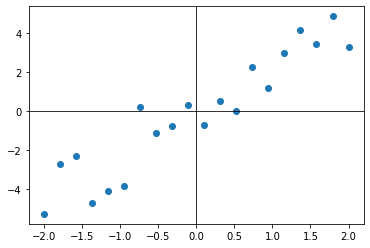

In [120]:
np.random.seed(44)
x_points = np.linspace(-2, 2, 20)
noise = np.random.normal(loc=0, scale=np.sqrt(1), size=20)
y_points = 2.25 * x_points + noise

x_points = x_points.reshape((-1, 1))
y_points = y_points.reshape((-1, 1))

fig = plt.figure()
plt.axhline(y=0, c='black', linewidth=0.8)
plt.axvline(x=0, c='black', linewidth=0.8)
plt.scatter(x_points.flatten(), y_points.flatten())
plt.show()

#### Analytical solution:

We find the value of $\theta$ using the **Normal Equation**:
$\theta^* = (X^T X)^{-1} X^T y$

In [121]:
optimal_theta =  (1/(x_points.T @ x_points)) @ x_points.T @ y_points
print("optimal_theta: ", optimal_theta[0, 0])

optimal_theta:  2.2753373500501928


#### `a.` Iterative implementation:

$$Update\space step: \theta_{t+1} =  \theta_{t} - \alpha \frac{dJ}{d\theta}$$

In [122]:
theta = 0
m = len(x_points)
h = lambda theta, x: theta * x
J = lambda theta, x, y: (h(theta, x) - y)**2
learning_rate = 0.02
costs = []
theta_hist = []
epochs = 100

for i in range(epochs):
    theta_hist.append(theta)
    epoch_cost = 0
    epoch_update = 0
    for j in range(m):
        instnace_x = x_points[j]
        instance_y = y_points[j]
        instance_y_hat = h(theta, instnace_x)
        instance_cost = J(theta, instnace_x, instance_y)
        epoch_cost += (1/(2*m)) * instance_cost.item()
        instance_update = (instance_y_hat - instance_y) * instnace_x
        epoch_update += (1/m) * instance_update.item()
    costs.append(epoch_cost)
    theta = theta - learning_rate * epoch_update
hist = np.asarray(theta_hist)
print("Optimal theta: ", theta)

Optimal theta:  2.161108087678552


#### `B.` Semi-Vectorized implementation:

We deal with X and y as vectors rather than dealing with each data point seperately.

GD theta:  2.1611080876785516


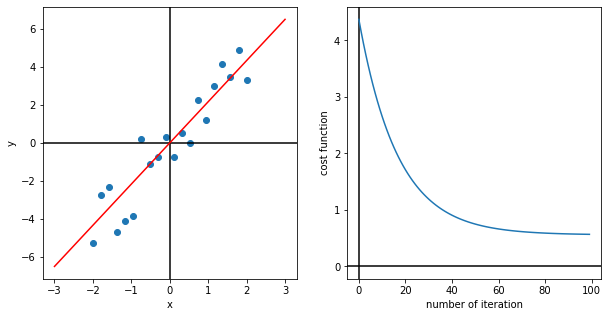

In [123]:
theta = 0
m = len(x_points)
h = lambda theta, x: theta * x
J = lambda theta, x, y: (1/(2*m)) * (h(theta, x) - y).T @ (h(theta, x) - y)
learning_rate = 0.02
costs = []
theta_hist = []
epochs = 100

for i in range(epochs):
    theta_hist.append(theta)
    y_hat = h(theta, x_points)
    cost = J(theta, x_points, y_points)
    costs.append(cost.item())
    grad = (1/m) * np.sum((h(theta, x_points) - y_points) * x_points)
    theta = theta - learning_rate * grad
hist = np.asarray(theta_hist)
print("GD theta: ", theta)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('x')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('y')
ax1.scatter(x_points.flatten(), y_points.flatten())
ax1.plot(range(-3, 4), h(theta, range(-3, 4)), c='red')

ax2 = fig.add_subplot(122)
ax2.axhline(y=0, c='black')
ax2.set_xlabel('number of iteration')
ax2.axvline(x=0, c='black')
ax2.set_ylabel('cost function')
ax2.plot(range(epochs), costs)

plt.show()

#### Cost function Visualization:

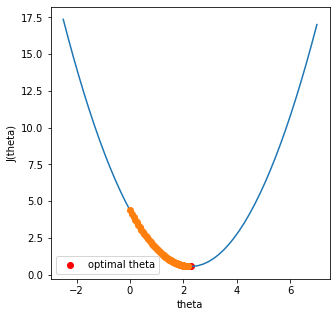

In [124]:
n = 50
X = np.linspace(-2.5, 7, n, endpoint=True)
Y = np.zeros(n)

for i in range(n):
    Y[i] = J(X[i], x_points, y_points)


fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('theta')
ax1.set_ylabel('J(theta)')
ax1.plot(X, Y)
ax1.plot(hist, costs, '-o')
ax1.scatter(optimal_theta[0, 0], J(optimal_theta[0, 0], x_points, y_points), c='red', label="optimal theta")

plt.legend()
plt.show()

### Single variable linear regression with two parameters:

Our goal is to find the best line that fit the data points.  
This optimization problem has a two parameters $\theta_0$ which defines the intercept of a line with the y-axis and $\theta_1$ that defines the slope of the line.  
$$Parameters: \theta_0, \theta_1$$  
$$Hypothesis: \hat{y} = h_{\theta_0, \theta_1}(x) = \theta_0 + \theta_1 x$$  
$$Cost function: J(\theta) = \frac{1}{2m} \sum_{1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2$$  
$$Gradients: \frac{dJ}{d\theta_0} = \frac{1}{m} \sum_{1}^{m}(h_\theta(x^{(i)}) - y^{(i)})$$  
$$\frac{dJ}{d\theta_1} = \frac{1}{m} \sum_{1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_1^{(i)}$$  
$$Goal: \theta^* = min_\theta  J(\theta) $$

#### Data:

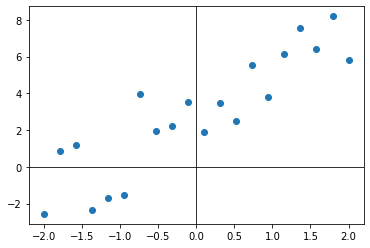

In [125]:
np.random.seed(44)
x_points = np.linspace(-2, 2, 20)
noise = np.random.normal(loc=0, scale=np.sqrt(2), size=20)
y_points = 3 + 2.25 * x_points + noise

x_points = x_points.reshape((-1, 1))
y_points = y_points.reshape((-1, 1))

fig = plt.figure()
plt.axhline(y=0, c='black', linewidth=0.8)
plt.axvline(x=0, c='black', linewidth=0.8)
plt.scatter(x_points.flatten(), y_points.flatten())
plt.show()

#### Analytical Solution:

Since we have 2 features, we add a column of ones to the x_points which gets multiplied by the intercept term $\theta_0$ so that we can use the equation $\theta X = y$.  
We solve this equation using the **Normal Equation**:
$\theta^* = (X^T X)^{-1} X^T y$

In [126]:
x_points_analytic = np.hstack((np.ones((20, 1)), x_points))
optimal_theta = (np.linalg.inv(x_points_analytic.T @ x_points_analytic)) @ x_points_analytic.T @ y_points
print("Optimal theta 0: ", optimal_theta[0, 0])
print("Optimal theta 1: ", optimal_theta[1, 0])

Optimal theta 0:  2.8387867499621593
Optimal theta 1:  2.2858324240755774


#### `a.` Semi-Vectorized implementation:

$$Update\space step: \theta_{(0) t+1} =  \theta_{(0) t} - \alpha \frac{\partial J}{\partial \theta_{(0)}}$$  
$$Update\space step: \theta_{(1) t+1} =  \theta_{(1) t} - \alpha \frac{\partial J}{\partial \theta_{(1)}}$$

GD theta_0:  2.806057767051916
GD theta_1:  2.2837137295860463


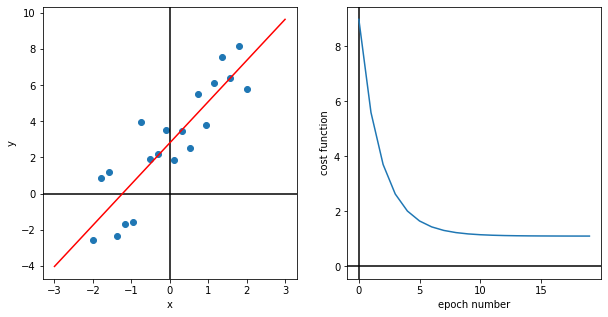

In [127]:
theta_0 = 0
theta_1 = 0
m = len(x_points)
h = lambda theta_0, theta_1, x: theta_0 + theta_1 * x
J = lambda theta_0, theta_1, x, y: (1/(2*m)) * (h(theta_0, theta_1, x) - y).T @ (h(theta_0, theta_1, x) - y)
learning_rate = 0.2
epochs=20
costs = []
theta_hist = []

for i in range(epochs):
    y_hat = h(theta_0, theta_1, x_points)
    cost = J(theta_0, theta_1, x_points, y_points)
    costs.append(cost.item())
    theta_hist.append([theta_0, theta_1])
    grad_0 = (1/m) * np.sum((y_hat - y_points))
    grad_1 = (1/m) * np.sum((y_hat - y_points) * x_points)
    theta_0 = theta_0 - learning_rate * grad_0
    theta_1 = theta_1 - learning_rate * grad_1

print("GD theta_0: ", theta_0)
print("GD theta_1: ", theta_1)

theta_hist = np.asarray(theta_hist)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('x')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('y')
ax1.scatter(x_points, y_points)
ax1.plot(range(-3, 4), h(theta_0, theta_1, range(-3, 4)), c='red')

ax2 = fig.add_subplot(122)
ax2.axhline(y=0, c='black')
ax2.set_xlabel('epoch number')
ax2.axvline(x=0, c='black')
ax2.set_ylabel('cost function')
ax2.plot(range(epochs), costs)

plt.show()

#### `b.` Vectorized implementation:

We deal with partial derivative w.r.t. each parameter as a vector **(gradient vector)** and compute it once rather than compute the partial derivative of each parameter seperately.  
This implementation can be genarlized to solve regression problems for any number of variables/parameters.  
Our input data $X$ is a matrix which is a matrix, where each row represents a data point and each column represents a feature. that's the transpose of the usual linear algebra form. 

$$ X = \begin{bmatrix} x_0^{(0)} & x_1^{(0)} & \ldots &x_n^{(0)}  \\ x_0^{(1)} & x_1^{(2)} & \ldots &x_n^{(3)} \\ \vdots & \vdots & \ldots & \vdots \\ x_0^{(m)} & x_1^{(m)} & \ldots &x_n^{(m)} \end{bmatrix} 
=\begin{bmatrix} \text{---} \hspace{-0.2cm} & {x^{(0)}}^T & \hspace{-0.2cm}\text{---} \\ \text{---} \hspace{-0.2cm} & {x^{(1)}}^T & \hspace{-0.2cm}\text{---} \\ & \vdots  & \\ \text{---} \hspace{-0.2cm} & {x^{(m)}}^T & \hspace{-0.2cm} \text{---} \end{bmatrix}, \space\space\space 
\theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix}, \space\space\space 
y = \begin{bmatrix} {y}^{(0)}  \\ {y}^{(1)} \\ \vdots \\ {y}^{(m)} \end{bmatrix} $$

$$ \hat y = \begin{bmatrix} \hat {y}^{(0)}  \\ \hat {y}^{(1)} \\ \vdots \\ \hat {y}^{(m)} \end{bmatrix}
=\begin{bmatrix}  {x^{(0)}}^T \theta \\ {x^{(1)}}^T \theta \\ \vdots \\ {x^{(m)}}^T  \theta \end{bmatrix}
=\begin{bmatrix} \text{---} \hspace{-0.2cm} & {x^{(0)}}^T & \hspace{-0.2cm}\text{---} \\ \text{---} \hspace{-0.2cm} & {x^{(1)}}^T & \hspace{-0.2cm}\text{---} \\ & \vdots  & \\ \text{---} \hspace{-0.2cm} & {x^{(m)}}^T & \hspace{-0.2cm} \text{---} \end{bmatrix}
\begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix}
= X \theta$$

$$ e = \begin{bmatrix} {e}^{(0)}  \\ {e}^{(1)} \\ \vdots \\ {e}^{(m)} \end{bmatrix}
= \begin{bmatrix} \hat {y}^{(0)} - {y}^{(0)} \\ \hat {y}^{(1)} - {y}^{(1)} \\ \vdots \\ \hat {y}^{(m)} - {y}^{(m)}\end{bmatrix}
= \hat y - y
$$

$$ J(\theta) = \frac{1}{2m} \sum_{1}^{m}(\hat y^{(i)} - y^{(i)})^2 = \frac{1}{2m} \sum_{1}^{m}(e^{(i)})^2 =\frac{1}{2m} e^T e$$

$$\frac{dJ}{d\theta_0} = \frac{1}{m} \sum_{1}^{m}({\hat y}^{(i)} - y^{(i)})x_0^{(i)} 
= \sum_{1}^{m} e^{(i)} x_0^{(i)} 
= {x_0^{(i)}}^T e
= \frac{1}{m} \begin{bmatrix} x_0^{(0)} & x_0^{(1)} & \ldots & x_0^{(m)} \end{bmatrix}
\begin{bmatrix} {e}^{(0)}  \\ {e}^{(1)} \\ \vdots \\ {e}^{(m)} \end{bmatrix}$$

$$\frac{dJ}{d\theta_1} = \frac{1}{m} \sum_{1}^{m}({\hat y}^{(i)} - y^{(i)})x_1^{(i)}
= \sum_{1}^{m} e^{(i)} x_1^{(i)} 
= {x_1^{(i)}}^T e
= \frac{1}{m} \begin{bmatrix} x_1^{(0)} & x_1^{(1)} & \ldots & x_1^{(m)} \end{bmatrix}
\begin{bmatrix} {e}^{(0)}  \\ {e}^{(1)} \\ \vdots \\ {e}^{(m)} \end{bmatrix}$$

$$\vdots$$

$$\frac{dJ}{d\theta_n} = \frac{1}{m} \sum_{1}^{m}({\hat y}^{(i)} - y^{(i)})x_n^{(i)}
= \sum_{1}^{m} e^{(i)} x_n^{(i)} 
= {x_n^{(i)}}^T e
= \frac{1}{m} \begin{bmatrix} x_n^{(0)} & x_n^{(1)} & \ldots & x_n^{(m)} \end{bmatrix}
\begin{bmatrix} {e}^{(0)}  \\ {e}^{(1)} \\ \vdots \\ {e}^{(m)} \end{bmatrix}$$

$$\nabla_\theta J(\theta) = \begin{bmatrix} \frac{dJ}{d\theta_0}\\ \frac{dJ}{d\theta_1}\\ \vdots\\ \frac{dJ}{d\theta_n} \end{bmatrix}
= \frac{1}{m} \begin{bmatrix} x_0^{(0)} & x_0^{(1)} & \ldots & x_0^{(m)} \\
x_1^{(0)} & x_1^{(1)} & \ldots & x_1^{(m)} \\ 
\vdots & \vdots & \ldots &\vdots \\
x_n^{(0)} & x_n^{(1)} & \ldots & x_n^{(m)} \\
\end{bmatrix}
\begin{bmatrix} {e}^{(0)}  \\ {e}^{(1)} \\ \vdots \\ {e}^{(m)} \end{bmatrix}
=\frac{1}{m} X^T e$$


$$Input: X$$
$$Parameters: \theta$$  
$$Hypothesis: h_{\theta}(X) = X \theta$$  
$$Cost function: J(\theta) = \frac{1}{2m}(h_\theta(x^{(i)}) - y^{(i)})^T (h_\theta(x^{(i)}) - y^{(i)})$$  
$$Gradient: \nabla_\theta J(\theta) = \frac{1}{m} X^T (h_\theta(x^{(i)}) - y^{(i)})$$
$$Goal: \theta^* = min_\theta  J(\theta) $$  
$$Update\space step: \theta_{t+1} =  \theta_{t} - \alpha \nabla_\theta J(\theta)$$  

In [128]:
def GradientDescent(X, y, fit_intercept=False, lr=0.001, epochs=10):
    m, n = X.shape

    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
    thetas = np.zeros((n, 1))
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        thetas_hist.append(thetas)
        y_predicted = X @ thetas
        e = y_predicted - y
        cost = 1/(2*m) * e.T @ e
        costs.append(cost.item())
        grad_theta = 1/m * X.T @ e
        thetas = thetas - lr * grad_theta
    return thetas_hist, costs

GD theta_0:  2.797875521324355
GD theta_1:  2.2828283050232567


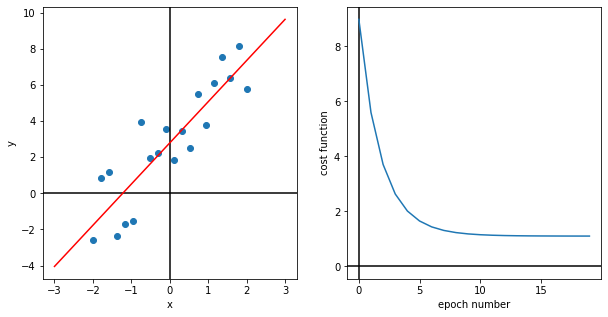

In [129]:
thetas_hist, costs = GradientDescent(x_points, y_points, fit_intercept=True, lr=0.2, epochs=20)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("GD theta_0: ", thetas_hist[-1][0])
print("GD theta_1: ", thetas_hist[-1][1])

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('x')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('y')
ax1.scatter(x_points, y_points)
ax1.plot(range(-3, 4), h(thetas_hist[-1][0], thetas_hist[-1][1], range(-3, 4)), c='red')

ax2 = fig.add_subplot(122)
ax2.axhline(y=0, c='black')
ax2.set_xlabel('epoch number')
ax2.axvline(x=0, c='black')
ax2.set_ylabel('cost function')
ax2.plot(range(len(costs)), costs)

plt.show()

#### Cost function Visualization:

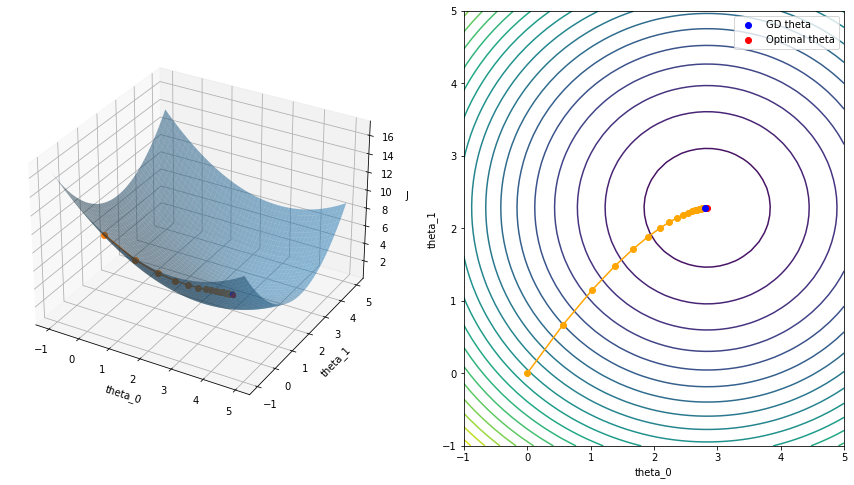

In [130]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
plot_cost(ax1, ax2, -1, 5, -1, 5, np.hstack([np.ones((x_points.shape[0], 1)), x_points]),
          y_points, thetas_hist, costs, optimal_theta, 'GD', ['theta_0', 'theta_1'])
plt.show()

## `2)` Stochastic Gradient Descent:

In [131]:
def StochasticGradientDescent(X, y, fit_intercept=True, lr=0.001, epochs=10, shuffle=True):
    m, n = X.shape
    if shuffle:
        np.random.seed(0)
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
    
    if fit_intercept:
        X = np.block([np.ones((m, 1)), X])
        n += 1
        
    thetas = np.zeros((n, 1))
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        for j in range(m):
            thetas_hist.append(thetas)
            x_point = X[[j]]
            y_point = y[[j]]
            y_predicted = x_point @ thetas
            e = y_predicted - y_point
            cost = (1/2) * e.T @ e
            costs.append(cost.item())
            grad_theta = x_point.T @ e
            thetas = thetas - lr * grad_theta
    return thetas_hist, costs

SGD theta_0:  2.7872774519329826
SGD theta_1:  2.6654891207665874


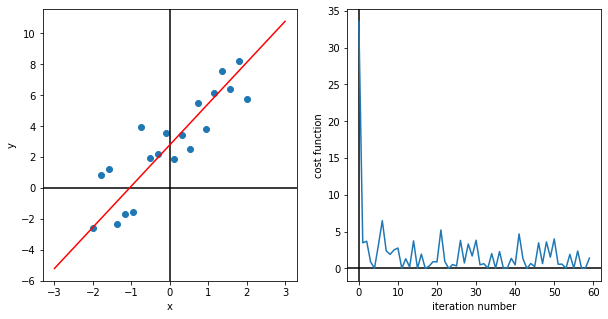

In [132]:
thetas_hist, costs = StochasticGradientDescent(x_points, y_points, fit_intercept=True, lr=0.1, epochs=3)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
theta_0 = thetas_hist[-1][0]
theta_1 = thetas_hist[-1][1]
print("SGD theta_0: ", theta_0.item())
print("SGD theta_1: ", theta_1.item())

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('x')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('y')
ax1.scatter(x_points, y_points)
ax1.plot(range(-3, 4), h(theta_0, theta_1, range(-3, 4)), c='red')

ax2 = fig.add_subplot(122)
ax2.axhline(y=0, c='black')
ax2.set_xlabel('iteration number')
ax2.axvline(x=0, c='black')
ax2.set_ylabel('cost function')
ax2.plot(range(len(costs)), costs)

plt.show()

#### Cost function Visualization:

Since the SDG is a stochastic algorithm that computes the cost of each data point seperately at different values of the parameters, we need to compute the true cost using the entire training data (not just a single data point) at each value we found for the parameters.

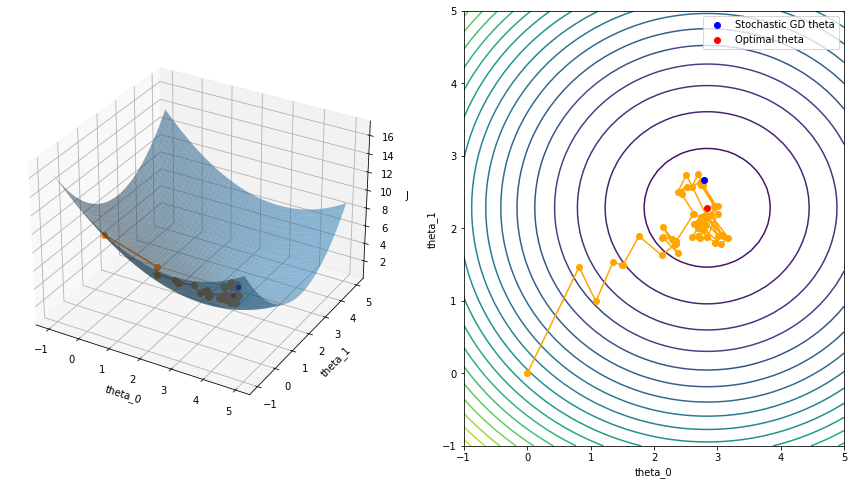

In [133]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
plot_cost(ax1, ax2, -1, 5, -1, 5, np.hstack([np.ones((x_points.shape[0], 1)), x_points]),
          y_points, thetas_hist, costs, optimal_theta, 'Stochastic GD', ['theta_0', 'theta_1'], stochastic=True)
plt.show()

## `3)` Mini-Batch Gradient Descent:

In [134]:
def MiniBatchGradientDescent(X, y, fit_intercept=True, lr=0.001, epochs=10, batch_size=5, shuffle=True):
    if shuffle:
        np.random.seed(0)
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
        
    m, n = x_points.shape
    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
        
    n_batches = m//batch_size
    thetas = np.zeros((n, 1))
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        for j in range(n_batches):
            thetas_hist.append(thetas)
            x_batch = X[j*batch_size: (j+1)*batch_size]
            y_batch = y[j*batch_size: (j+1)*batch_size]
            y_predicted_batch = x_batch @ thetas
            e = y_predicted_batch - y_batch
            cost = (1/2 * batch_size) * e.T @ e
            costs.append(cost.item())
            grad_theta = (1/batch_size) * x_batch.T @ e
            thetas = thetas - lr * grad_theta
    return thetas_hist, costs

mini-batch theta_0:  2.658634081584298
mini-batch theta_1:  2.2364395042218703


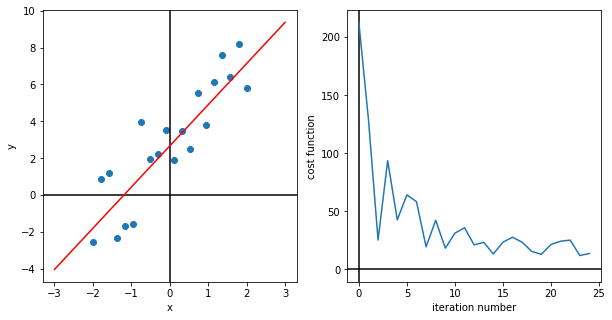

In [135]:
thetas_hist, costs = MiniBatchGradientDescent(x_points, y_points, fit_intercept=True, lr=0.1, epochs=5, batch_size=4, shuffle=True)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
theta_0 = thetas_hist[-1][0]
theta_1 = thetas_hist[-1][1]
print("mini-batch theta_0: ", theta_0.item())
print("mini-batch theta_1: ", theta_1.item())

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('x')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('y')
ax1.scatter(x_points, y_points)
ax1.plot(range(-3, 4), h(theta_0, theta_1, range(-3, 4)), c='red')

ax2 = fig.add_subplot(122)
ax2.axhline(y=0, c='black')
ax2.set_xlabel('iteration number')
ax2.axvline(x=0, c='black')
ax2.set_ylabel('cost function')
ax2.plot(range(len(costs)), costs)

plt.show()

#### Cost function Visualization:

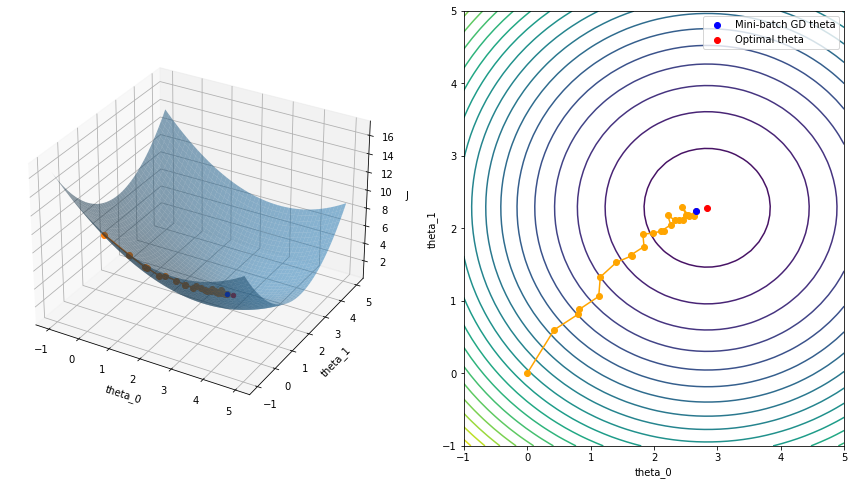

In [136]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
plot_cost(ax1, ax2, -1, 5, -1, 5, np.hstack([np.ones((x_points.shape[0], 1)), x_points])
          , y_points, thetas_hist, costs, optimal_theta,
          'Mini-batch GD', ['theta_0', 'theta_1'], stochastic=True)
plt.show()

## Hyperparameters:

### Learning Rate effect:

#### Very small learning rate:  
With very small learning rate, the magnitude of the update step is very small.  
This means that the algorithm will eventually converge to the optimal parameters value but with need a big number of epochs.

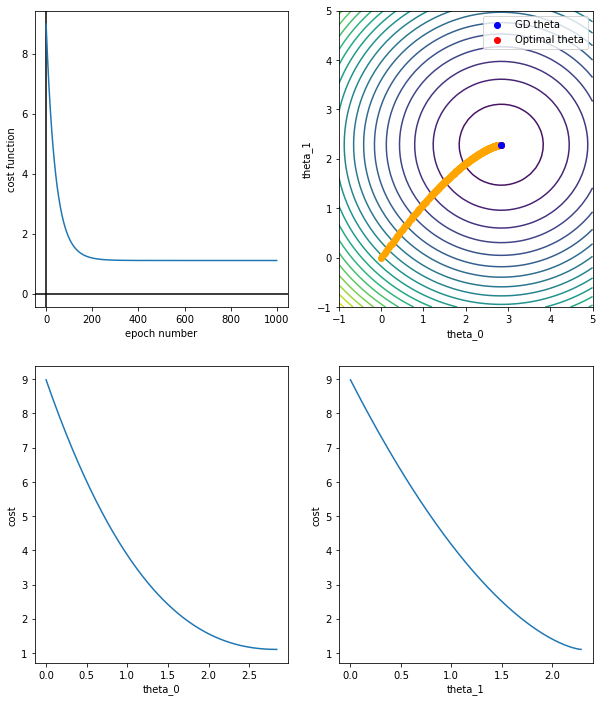

In [137]:
thetas_hist, costs = GradientDescent(x_points, y_points, fit_intercept=True, lr=0.01, epochs=1000)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))

fig = plt.figure(figsize=(10, 12))
ax1 = fig.add_subplot(221)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('epoch number')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('cost function')
ax1.plot(range(len(costs)), costs)

ax2 = fig.add_subplot(222)
plot_cost_contours(ax2, -1, 5, -1, 5, np.hstack([np.ones((x_points.shape[0], 1)), x_points]),
                    y_points, thetas_hist, costs, optimal_theta, 'GD', ['theta_0', 'theta_1'])

ax3 = fig.add_subplot(223)
ax3.set_xlabel('theta_0')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 0], costs)


ax4 = fig.add_subplot(224)
ax4.set_xlabel('theta_1')
ax4.set_ylabel('cost')
ax4.plot(thetas_hist[:, 1], costs)
plt.show()

#### Normal learning rate:
With an optimal value of learning rate, the algorithm will converge to the optimal parameters with a reasonable number of epochs.

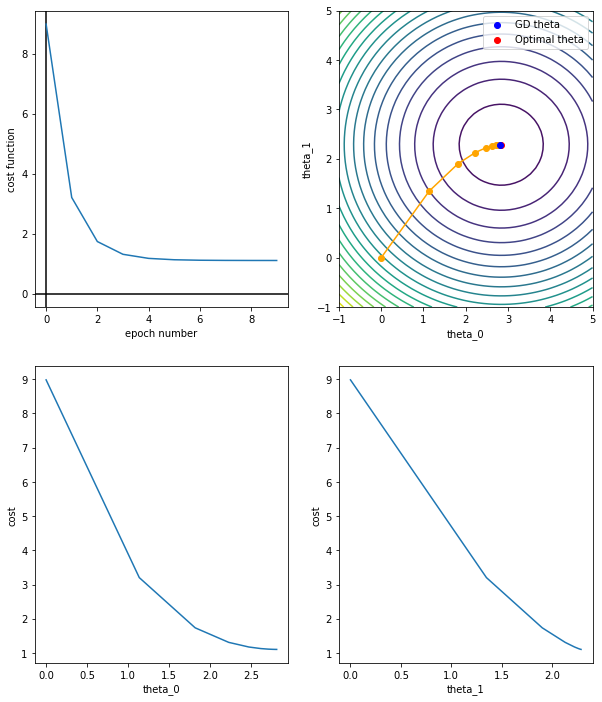

In [138]:
thetas_hist, costs = GradientDescent(x_points, y_points, fit_intercept=True, lr=0.4, epochs=10)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))

fig = plt.figure(figsize=(10, 12))

ax1 = fig.add_subplot(221)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('epoch number')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('cost function')
ax1.plot(range(len(costs)), costs)

ax2 = fig.add_subplot(222)
plot_cost_contours(ax2, -1, 5, -1, 5, np.hstack([np.ones((x_points.shape[0], 1)), x_points]),
                    y_points, thetas_hist, costs, optimal_theta, 'GD', ['theta_0', 'theta_1'])

ax3 = fig.add_subplot(223)
ax3.set_xlabel('theta_0')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 0], costs)


ax3 = fig.add_subplot(224)
ax3.set_xlabel('theta_1')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 1], costs)
plt.show()

#### Large learning rate:
With a large learning rate, the magnitude of the update step is big, which makes the algorithm oscillate around the optimal solution but as it gets closer to it, the gradient magnitude becomes smaller which makes the update step get smaller and the algorithm will eventually converge to a close value to the optimal solution.

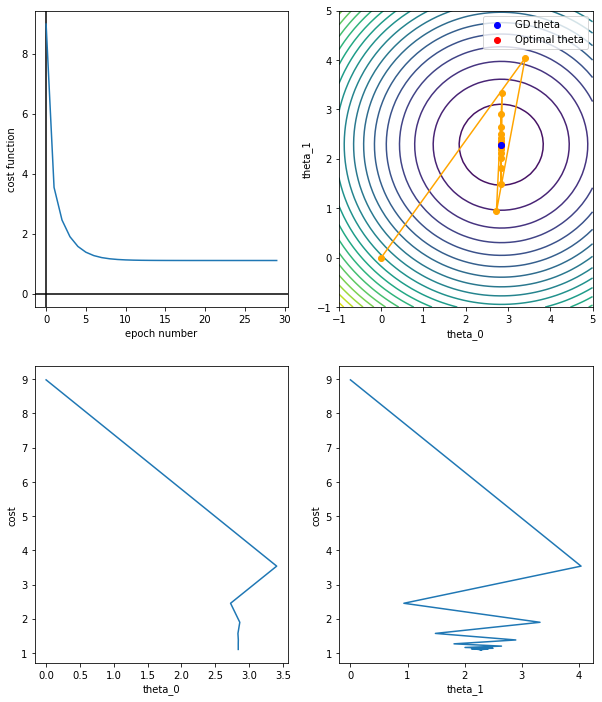

In [139]:
thetas_hist, costs = GradientDescent(x_points, y_points, fit_intercept=True, lr=1.2, epochs=30)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))

fig = plt.figure(figsize=(10, 12))

ax1 = fig.add_subplot(221)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('epoch number')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('cost function')
ax1.plot(range(len(costs)), costs)

ax2 = fig.add_subplot(222)
plot_cost_contours(ax2, -1, 5, -1, 5, np.hstack([np.ones((x_points.shape[0], 1)), x_points]),
                    y_points, thetas_hist, costs, optimal_theta, 'GD', ['theta_0', 'theta_1'])

ax3 = fig.add_subplot(223)
ax3.set_xlabel('theta_0')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 0], costs)


ax3 = fig.add_subplot(224)
ax3.set_xlabel('theta_1')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 1], costs)
plt.show()

#### Very large learning rate:
With a very large learning rate, the magnitude of the update step is vert big, which makes the algorithm jump to a parameter value more far away from the optimal solution than the parameters we started with, this makes the gradient becomes bigger and the update step bigger as the number of epochs increase.  
This makes the algorithm diverge from the optimal solution.

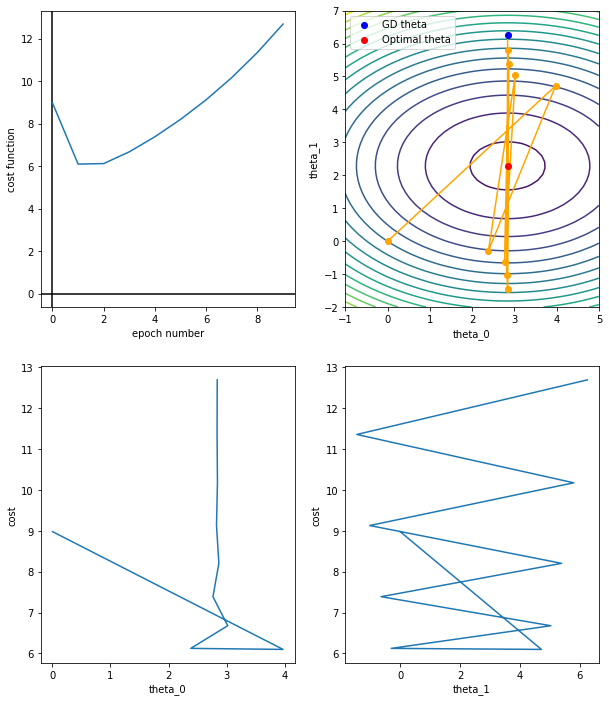

In [140]:
thetas_hist, costs = GradientDescent(x_points, y_points, fit_intercept=True, lr=1.4, epochs=10)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))

fig = plt.figure(figsize=(10, 12))

ax1 = fig.add_subplot(221)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('epoch number')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('cost function')
ax1.plot(range(len(costs)), costs)

ax2 = fig.add_subplot(222)
plot_cost_contours(ax2, -1, 5, -2, 7, np.hstack([np.ones((x_points.shape[0], 1)), x_points]),
                    y_points, thetas_hist, costs, optimal_theta, 'GD', ['theta_0', 'theta_1'])

ax3 = fig.add_subplot(223)
ax3.set_xlabel('theta_0')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 0], costs)


ax3 = fig.add_subplot(224)
ax3.set_xlabel('theta_1')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 1], costs)
plt.show()

### Batch Size effect:

#### Very small batch size:
There are a lot of oscillations and the behaviour of the algorithm becomes similar to stochastic gradient descent.

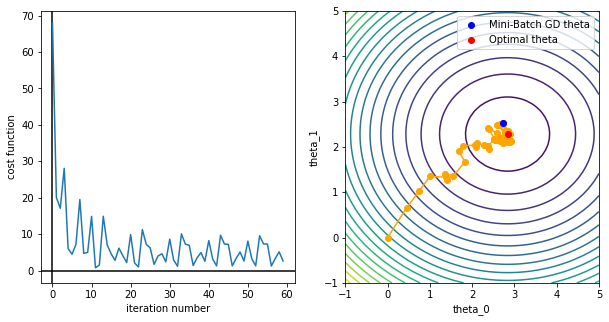

In [141]:
thetas_hist, costs = MiniBatchGradientDescent(x_points, y_points, fit_intercept=True, lr=0.1, epochs=6, batch_size=2, shuffle=True)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('iteration number')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('cost function')
ax1.plot(range(len(costs)), costs)

ax2 = fig.add_subplot(122)
plot_cost_contours(ax2, -1, 5, -1, 5, np.hstack([np.ones((x_points.shape[0], 1)), x_points]),
                    y_points, thetas_hist, costs, optimal_theta, 'Mini-Batch GD', ['theta_0', 'theta_1'], stochastic=True)

plt.legend()
plt.show()

#### Normal batch size:
The are some oscillations but they are less and smoother than the osccilations of SGD.

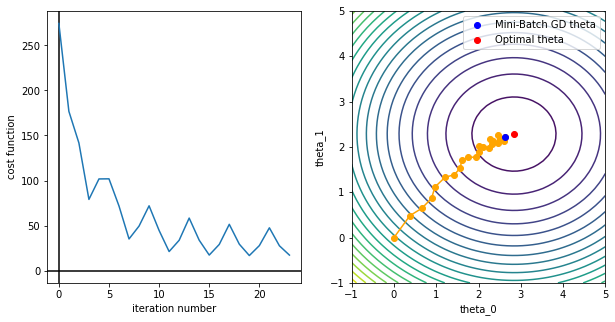

In [142]:
thetas_hist, costs = MiniBatchGradientDescent(x_points, y_points, fit_intercept=True, lr=0.1, epochs=6, batch_size=5, shuffle=True)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('iteration number')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('cost function')
ax1.plot(range(len(costs)), costs)

ax2 = fig.add_subplot(122)
plot_cost_contours(ax2, -1, 5, -1, 5, np.hstack([np.ones((x_points.shape[0], 1)), x_points]),
                    y_points, thetas_hist, costs, optimal_theta, 'Mini-Batch GD', ['theta_0', 'theta_1'], stochastic=True)

plt.legend()
plt.show()

#### Very large batch size:
The are nearly no oscillations and the behviour of the algorithm is similar to batch gradient descent.

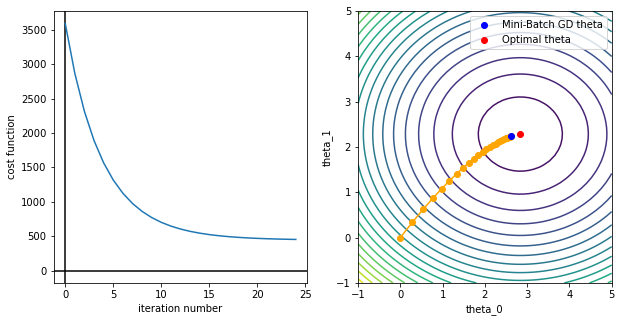

In [143]:
thetas_hist, costs = MiniBatchGradientDescent(x_points, y_points, fit_intercept=True, lr=0.1, epochs=25, batch_size=20, shuffle=True)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.axhline(y=0, c='black')
ax1.set_xlabel('iteration number')
ax1.axvline(x=0, c='black')
ax1.set_ylabel('cost function')
ax1.plot(range(len(costs)), costs)

ax2 = fig.add_subplot(122)
plot_cost_contours(ax2, -1, 5, -1, 5, np.hstack([np.ones((x_points.shape[0], 1)), x_points]),
                    y_points, thetas_hist, costs, optimal_theta, 'Mini-Batch GD', ['theta_0', 'theta_1'], stochastic=True)

plt.legend()
plt.show()

## Feature Scaling

Gradient descent requires the data features to have a similar scale to work efficiently.  

### Data points

Here, we have 2 featrues with different scales; $x_1 \in [-10, 10]$ and $x_2 \in [-1, 1]$.  
if we assume that $y$ is held constant, then the parameter $\theta_1$ will be very small compared to $\theta_2$.

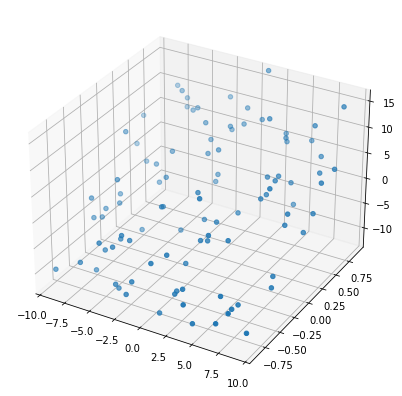

In [144]:
np.random.seed(44)
x1_points = np.linspace(-10, 10, 100)
x2_points = np.random.uniform(low=-1, high=1, size=(100,))
noise = np.random.normal(loc=0, scale=np.sqrt(9), size=100)
y_points = 0.1 * x1_points + 10 * x2_points + noise

x_points = np.hstack([x1_points.reshape(-1, 1), x2_points.reshape(-1, 1)])
y_points = y_points.reshape((-1, 1))


plt.figure(figsize = (10, 7))
plt3d = plt.axes(projection='3d')
plt3d.scatter(x_points[:, 0], x_points[:, 1], y_points)
plt3d.set_xlim3d(x1_points.min(), x1_points.max())
plt3d.set_ylim3d(x2_points.min(), x2_points.max())
plt3d.set_zlim3d(y_points.min(), y_points.max())
plt.show();

### Analytic solution:

Optimal theta 0:  0.12693199765756036
Optimal theta 1:  10.08242582298929


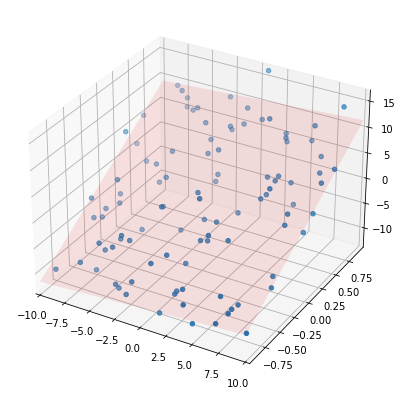

In [145]:
x_points_analytic = x_points.copy()
optimal_theta = (np.linalg.inv(x_points_analytic.T @ x_points_analytic)) @ x_points_analytic.T @ y_points
print("Optimal theta 0: ", optimal_theta[0, 0])
print("Optimal theta 1: ", optimal_theta[1, 0])

plt.figure(figsize = (10, 7))
ax = plt.axes(projection='3d')
visualize_best_fit_surface(ax, -10, 11, -1, 2, x_points, y_points, optimal_theta)
plt.show();

Defining GD with a different starting point for a better visualization

In [146]:
def GradientDescent(X, y, fit_intercept=True, lr=0.001, epochs=10):
    m, n = X.shape

    if fit_intercept:
        X = np.hstack([np.ones((m, 1)), X])
        n += 1
    thetas = np.array([[-5], [5]])
    thetas_hist = []
    costs = []
    
    for i in range(epochs):
        thetas_hist.append(thetas)
        y_predicted = X @ thetas
        e = y_predicted - y
        cost = 1/(2*m) * e.T @ e
        costs.append(cost.item())
        grad_theta = 1/m * X.T @ e
        thetas = thetas - lr * grad_theta
    return thetas_hist, costs

Since the gradient component for each parameter is computed using $\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_i^m (h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j$ then gradient component depends on the corresponding feature value and scale.  
For $\theta_1$, since the corresponding $x_1$ values have a big scale, its gradient component will be very big compared to its optimal value, so the algorithm will oscillate around its optimal value.  
For $\theta_2$, since the corresponding $x_2$ values have a small scale, its gradient component will be very small and it will take very small steps and will need many iterations to reach its optimal value.

GD theta_0:  0.12508642775653087
GD theta_1:  9.375289427378009


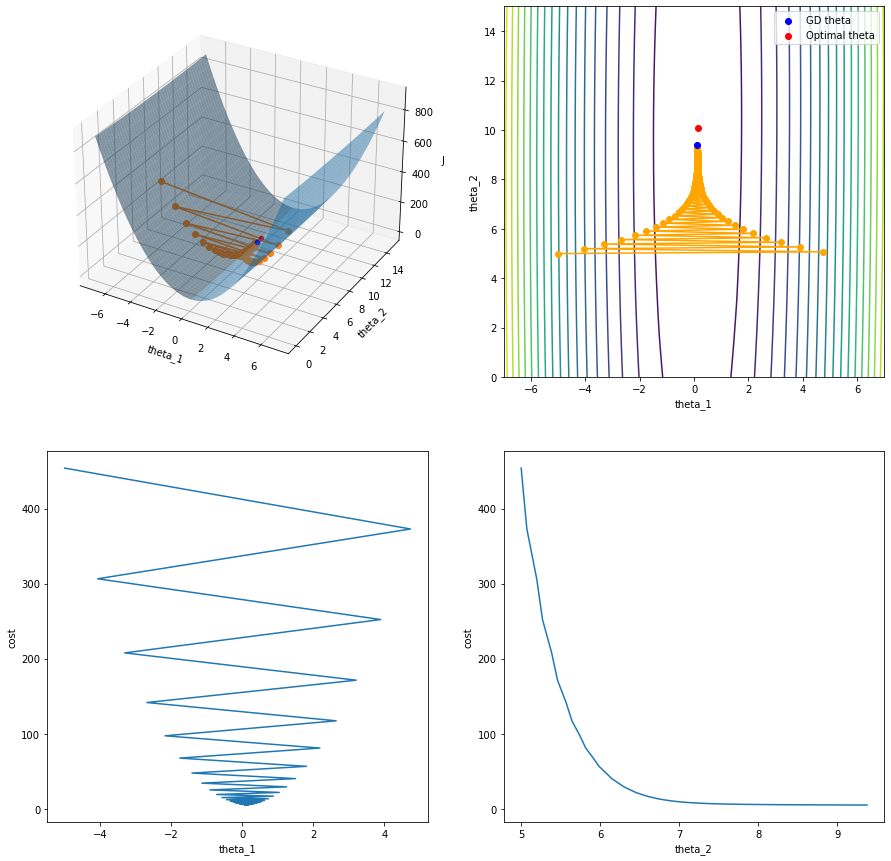

In [147]:
thetas_hist, costs = GradientDescent(x_points, y_points, fit_intercept=False, lr=0.056, epochs=100)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
theta_0 = thetas_hist[-1][0]
theta_1 = thetas_hist[-1][1]
print("GD theta_0: ", theta_0.item())
print("GD theta_1: ", theta_1.item())


fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
plot_cost(ax1, ax2, -7, 7, 0, 15, x_points, y_points, thetas_hist, costs, optimal_theta, 'GD', ['theta_1', 'theta_2'])

ax3 = fig.add_subplot(223)
ax3.set_xlabel('theta_1')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 0], costs)


ax4 = fig.add_subplot(224)
ax4.set_xlabel('theta_2')
ax4.set_ylabel('cost')
ax4.plot(thetas_hist[:, 1], costs)
plt.show()

### After scaling:

`1.` Min-Max Normalization:
$$ x' = \frac{x-x_{min}}{x_{max} - x_{min}}$$

In [161]:
x_points_scaled = (x_points - np.min(x_points, axis=0))/(np.max(x_points, axis=0) - np.min(x_points, axis=0))

In [162]:
x_points_analytic = x_points_scaled.copy()
optimal_theta = (np.linalg.inv(x_points_analytic.T @ x_points_analytic)) @ x_points_analytic.T @ y_points
print("Optimal theta 0: ", optimal_theta[0, 0])
print("Optimal theta 1: ", optimal_theta[1, 0])

Optimal theta 0:  -7.543194441898478
Optimal theta 1:  10.37389071484236


GD theta_0:  -7.5043785546175314
GD theta_1:  10.33590565242409


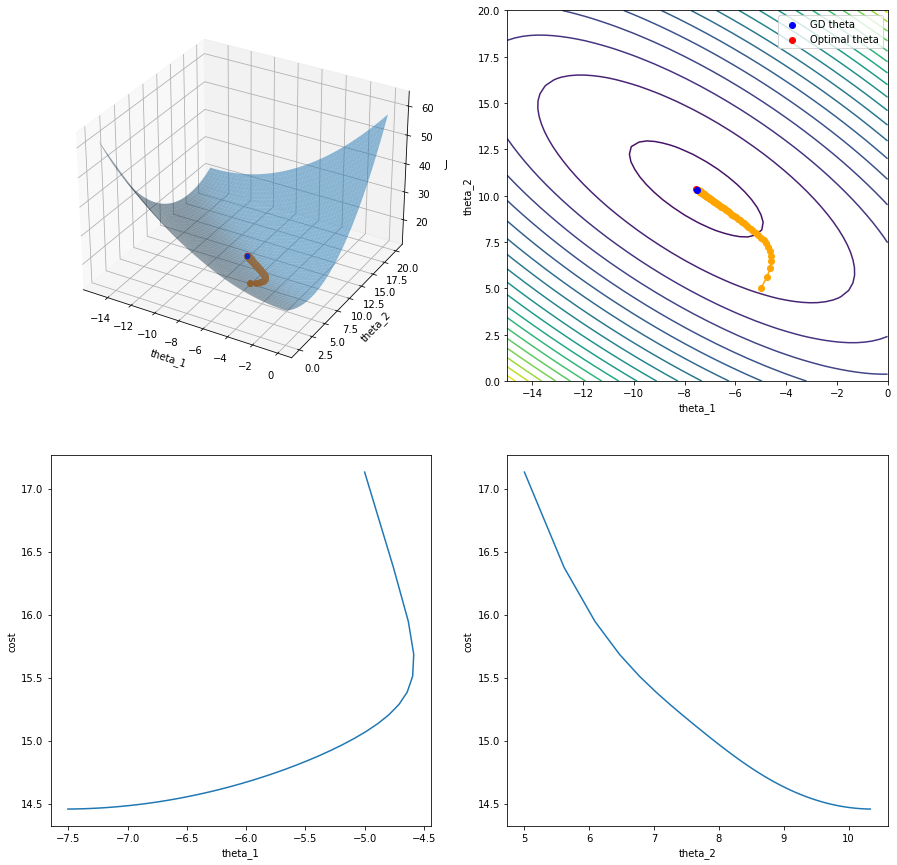

In [166]:
thetas_hist, costs = GradientDescent(x_points_scaled, y_points, fit_intercept=False, lr=0.5, epochs=100)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("GD theta_0: ", thetas_hist[-1][0])
print("GD theta_1: ", thetas_hist[-1][1])
    
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
plot_cost(ax1, ax2, -15, 0, 0, 20, x_points_scaled, y_points, thetas_hist, costs, optimal_theta, 'GD', ['theta_1', 'theta_2'])


ax3 = fig.add_subplot(223)
ax3.set_xlabel('theta_1')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 0], costs)


ax4 = fig.add_subplot(224)
ax4.set_xlabel('theta_2')
ax4.set_ylabel('cost')
ax4.plot(thetas_hist[:, 1], costs)
plt.show()

Now both features have similar scale $[0, 1]$ and their gradient components are similar, so both of them change with similar steps.

`2.` Standardization:
$$ x' = \frac{x - \bar{x}}{\sigma_x}

In [156]:
x_points_scaled = (x_points - np.mean(x_points, axis=0)) / np.std(x_points, axis=0)

In [157]:
x_points_analytic = x_points_scaled.copy()
optimal_theta = (np.linalg.inv(x_points_analytic.T @ x_points_analytic)) @ x_points_analytic.T @ y_points
print("Optimal theta 0: ", optimal_theta[0, 0])
print("Optimal theta 1: ", optimal_theta[1, 0])

Optimal theta 0:  0.740416554089431
Optimal theta 1:  5.996786833095362


GD theta_0:  0.7404165540894312
GD theta_1:  5.996786833095359


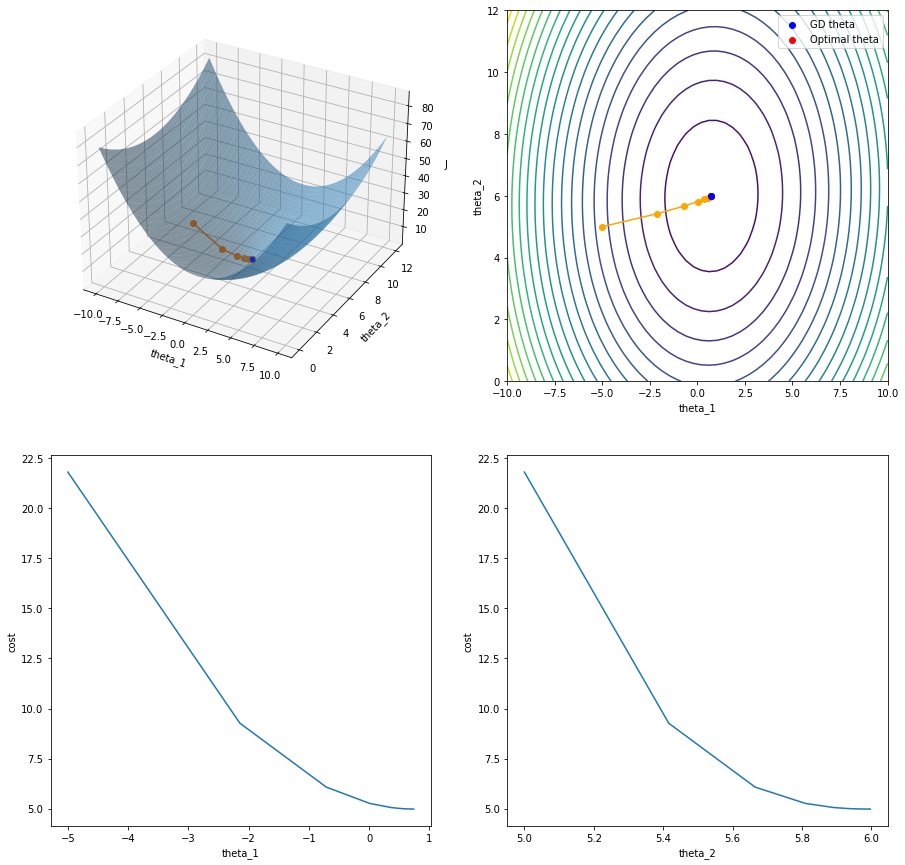

In [160]:
thetas_hist, costs = GradientDescent(x_points_scaled, y_points, fit_intercept=False, lr=0.5, epochs=100)
thetas_hist = np.asarray(thetas_hist).reshape((-1, 2))
print("GD theta_0: ", thetas_hist[-1][0])
print("GD theta_1: ", thetas_hist[-1][1])
    
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
plot_cost(ax1, ax2, -10, 10, 0, 12, x_points_scaled, y_points, thetas_hist, costs, optimal_theta, 'GD', ['theta_1', 'theta_2'])


ax3 = fig.add_subplot(223)
ax3.set_xlabel('theta_1')
ax3.set_ylabel('cost')
ax3.plot(thetas_hist[:, 0], costs)


ax4 = fig.add_subplot(224)
ax4.set_xlabel('theta_2')
ax4.set_ylabel('cost')
ax4.plot(thetas_hist[:, 1], costs)
plt.show()